In [1]:

import random
import warnings
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import itertools
from itertools import combinations, permutations, chain


warnings.filterwarnings("ignore")
import networkx as nx
import matplotlib.pyplot as plt
import json

from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete.CPD import TabularCPD

# Asia Network

In [2]:
def is_valid_subset(G, subset):
    """
    Checks if a subset of nodes is valid under do-intervention rules.
    Each node in the subset must include all its predecessors from the graph.
    """
    # check whether the input subset is valid (must have a route to y)
    subG = G.subgraph(subset).copy()
    
    if not nx.is_connected(subG.to_undirected()):
        return False

    for node in subset:
        parents = set(G.predecessors(node))
        parents_included = parents.intersection(subset)
        if len(parents_included) != 0:
            if len(parents_included) < len(parents):
                return False
    return True

In [1374]:
G = nx.DiGraph()

G.add_nodes_from(["asia", "smoke", "tub", "lung", "bronc", "either", "xray", "dysp"])
edges = [
    # tuple of direction (from, to)
    ("asia", "tub"),
    ("smoke", "lung"),
    ("smoke", "bronc"),
    ("tub", "either"),
    ("lung", "either"),
    ("either", "xray"),
    ("either", "dysp"),
    ("bronc", "dysp"),
]
G.add_edges_from(edges)

# initiate BN
dataset = pd.read_csv('../data/asia10K.csv')
asia_bn = BayesianNetwork(edges)
asia_bn.fit(dataset)
asia_bn.get_cpds()

[<TabularCPD representing P(asia:2) at 0x14fd3ae09d0>,
 <TabularCPD representing P(tub:2 | asia:2) at 0x14fd3ae06a0>,
 <TabularCPD representing P(smoke:2) at 0x14fd3ae0580>,
 <TabularCPD representing P(lung:2 | smoke:2) at 0x14fd3ae05e0>,
 <TabularCPD representing P(bronc:2 | smoke:2) at 0x14fd3ae0bb0>,
 <TabularCPD representing P(either:2 | lung:2, tub:2) at 0x14fd3ae0880>,
 <TabularCPD representing P(xray:2 | either:2) at 0x14fd325afd0>,
 <TabularCPD representing P(dysp:2 | bronc:2, either:2) at 0x14fd325a970>]

In [4]:
valid_combination = []
for r in range(1, len(G.nodes)):
    for comb in combinations(set(G.nodes) - {'lung'}, r):
        if is_valid_subset(G, set(comb) | {'lung'}):
            valid_combination.append(set(comb) | {'lung'})
valid_combination

[{'lung', 'smoke'},
 {'either', 'lung', 'tub'},
 {'bronc', 'lung', 'smoke'},
 {'either', 'lung', 'tub', 'xray'},
 {'asia', 'either', 'lung', 'tub'},
 {'either', 'lung', 'smoke', 'tub'},
 {'asia', 'either', 'lung', 'tub', 'xray'},
 {'either', 'lung', 'smoke', 'tub', 'xray'},
 {'asia', 'either', 'lung', 'smoke', 'tub'},
 {'bronc', 'dysp', 'either', 'lung', 'tub'},
 {'bronc', 'either', 'lung', 'smoke', 'tub'},
 {'asia', 'either', 'lung', 'smoke', 'tub', 'xray'},
 {'bronc', 'dysp', 'either', 'lung', 'tub', 'xray'},
 {'bronc', 'either', 'lung', 'smoke', 'tub', 'xray'},
 {'asia', 'bronc', 'dysp', 'either', 'lung', 'tub'},
 {'asia', 'bronc', 'either', 'lung', 'smoke', 'tub'},
 {'bronc', 'dysp', 'either', 'lung', 'smoke', 'tub'},
 {'asia', 'bronc', 'dysp', 'either', 'lung', 'tub', 'xray'},
 {'asia', 'bronc', 'either', 'lung', 'smoke', 'tub', 'xray'},
 {'bronc', 'dysp', 'either', 'lung', 'smoke', 'tub', 'xray'},
 {'asia', 'bronc', 'dysp', 'either', 'lung', 'smoke', 'tub'},
 {'asia', 'bronc', 'd

In [5]:
def intervention(bn, G, subset):
    other = set(G.nodes) - subset
    
    for node in other:
        parents = set(G.predecessors(node))
        parent_included = parents.intersection(subset)
        if len(parent_included) > 0:
            bn = bn.do(node)

        childs = set(G.successors(node))
        child_included = childs.intersection(subset)
        if len(child_included) > 0:
            bn = bn.do(child_included)
            
    return bn
    
bn = intervention(asia_bn, G, valid_combination[4])
bn.get_cpds()

[<TabularCPD representing P(asia:2) at 0x14fbf4e7ac0>,
 <TabularCPD representing P(tub:2 | asia:2) at 0x14fbf4e77f0>,
 <TabularCPD representing P(smoke:2) at 0x14fbf4e7a60>,
 <TabularCPD representing P(lung:2) at 0x14fbf4e7580>,
 <TabularCPD representing P(bronc:2 | smoke:2) at 0x14fbf4e7a00>,
 <TabularCPD representing P(either:2 | lung:2, tub:2) at 0x14fbf4e7dc0>,
 <TabularCPD representing P(xray:2) at 0x14fbf4e7c10>,
 <TabularCPD representing P(dysp:2) at 0x14fbf4e73a0>]

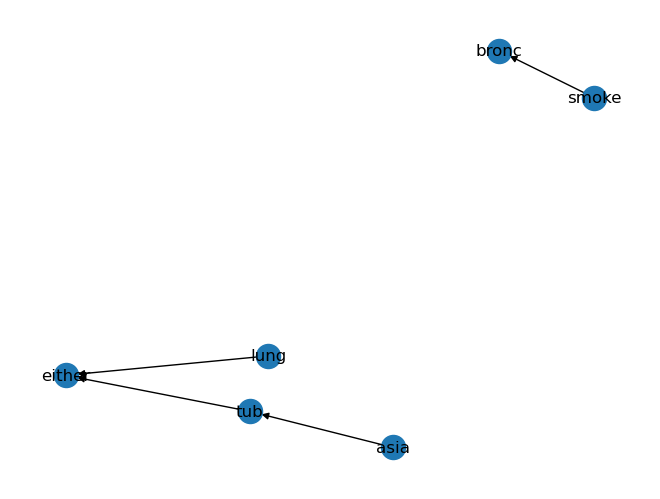

In [6]:
import matplotlib.pyplot as plt
nx.draw(nx.DiGraph(list(bn.edges)), with_labels=True)
plt.show()

# Shapley value feature i (individual data point)

In [1375]:
def intervention(bn, G, subset):
    print(subset)
    other = set(G.nodes) - subset
    
    for node in other:
        parents = set(G.predecessors(node))
        parent_included = parents.intersection(subset)
        if len(parent_included) > 0:
            bn = bn.do(node)

        childs = set(G.successors(node))
        child_included = childs.intersection(subset)
        if len(child_included) > 0:
            bn = bn.do(child_included)
            
    return bn
    
# bn = intervention(asia_bn, G, {'either', 'xray', 'smoke', 'lung', 'dysp', 'tub', 'bronc', 'asia'})
# bn.get_cpds()

### Approximate Shapley estimation for single feature value

https://christophm.github.io/interpretable-ml-book/shapley.html

In [1376]:

def random_subset(input_list):
    length = len(input_list)
    # Randomly decide the number of elements in the subset
    # random.seed(2)
    # n = random.randint(0, length)
    n = 4
    # Sample 'n' elements from the list
    subset = random.sample(input_list, n)
    return subset

# Example usage:
input_list = [0, 1, 2, 3, 4]
subset = random_subset(input_list)
print(subset)

[2, 3, 0, 4]


In [1411]:
def predict_proba(query, target):
    probabilities = query.values
    state_names = query.state_names[target]
    proba = {}
    
    for state, probability in zip(state_names, probabilities):
        print(f'Probability of [{target} = {state}] = {probability}')
        proba[target+'='+state] = probability
    return proba

In [1412]:
valid_combination

[{'lung', 'smoke'},
 {'either', 'lung', 'tub'},
 {'bronc', 'lung', 'smoke'},
 {'either', 'lung', 'tub', 'xray'},
 {'asia', 'either', 'lung', 'tub'},
 {'either', 'lung', 'smoke', 'tub'},
 {'asia', 'either', 'lung', 'tub', 'xray'},
 {'either', 'lung', 'smoke', 'tub', 'xray'},
 {'asia', 'either', 'lung', 'smoke', 'tub'},
 {'bronc', 'dysp', 'either', 'lung', 'tub'},
 {'bronc', 'either', 'lung', 'smoke', 'tub'},
 {'asia', 'either', 'lung', 'smoke', 'tub', 'xray'},
 {'bronc', 'dysp', 'either', 'lung', 'tub', 'xray'},
 {'bronc', 'either', 'lung', 'smoke', 'tub', 'xray'},
 {'asia', 'bronc', 'dysp', 'either', 'lung', 'tub'},
 {'asia', 'bronc', 'either', 'lung', 'smoke', 'tub'},
 {'bronc', 'dysp', 'either', 'lung', 'smoke', 'tub'},
 {'asia', 'bronc', 'dysp', 'either', 'lung', 'tub', 'xray'},
 {'asia', 'bronc', 'either', 'lung', 'smoke', 'tub', 'xray'},
 {'bronc', 'dysp', 'either', 'lung', 'smoke', 'tub', 'xray'},
 {'asia', 'bronc', 'dysp', 'either', 'lung', 'smoke', 'tub'},
 {'asia', 'bronc', 'd

# Checkpoint here!

In [1428]:
# Output: Shapley value for the value of the j-th feature
# Required: Number of iterations M, instance of interest x, 
# feature index j, data matrix X, and machine learning model f

# iterations
M = 100
feature_of_interest = 'smoke'
target = 'lung'
j = dataset.drop(columns=['lung']).columns.tolist().index(feature_of_interest)
columns = dataset.drop(columns=['lung']).columns
n_features = len(dataset.drop(columns=['lung']).columns)
feature_idxs = list(range(n_features))
feature_idxs.remove(j)

sample_idx = 0
# this is datapoint we interested in
x = dataset.iloc[sample_idx]
print(columns)
marginal_contributions = []

for m in range(M):
    # in BN, we cant just randomize feature to know the absence of feature,
    # however we have to delete the arcs of the coresponding nodes
    
    # x_j_idx = random.sample(feature_idxs, min(max(int(0.2*n_features), random.choice(feature_idxs)), int(0.8*n_features))) + [j]
    random.seed(150)
    x_j_idx = set(random_subset(feature_idxs) + [j])
    # x_idx = [idx for idx in feature_idxs if idx not in x_idx]
    
    x_idx = set(x_j_idx) - set([j])
    
    print(x_j_idx, x_idx)
    # print(columns.tolist().index())
    j_cols = set([columns[c] for c in x_j_idx])
    cols = set([columns[c] for c in x_idx])
    print(j_cols, cols)
    
    # check j_cols is a valid subset or not
    j_model_valid = False
    for comb in valid_combination:
        # print(comb)
        if (comb == j_cols | {target}):
            print('w/ j valid')
            print(comb, j_cols)
            j_model_valid = True
            
    model_valid = False
    for comb in valid_combination:
        # print(comb)
        if (comb == cols | {target}):
            print('w.o j valid')
            print(comb, cols)
            model_valid = True
    
    p_j = 0
    p = 0
    
    
    # calculate marginal contribution
    
    
    # set model with j
    # assume all model valid (evaluate later)
    # if j_model_valid:
    print()
    print('MODEL WITH J')
    j_model_bn = intervention(bn, G, j_cols | set([target]))
    print(j_model_bn.get_cpds())
    j_model_infer = VariableElimination(j_model_bn)
    j_evidence = {}
    for j_col in j_cols:
        j_evidence[j_col] = x[j_col]
    # j_evidence = {'either': 'yes', 'xray': 'yes', 'asia': 'yes', 'smoke': 'yes', 'tub': 'yes'}

    j_q = j_model_infer.query(variables=[target], evidence=j_evidence, joint=True)
    j_q_proba = predict_proba(j_q, target=target)
    p_j = j_q_proba[target+'=yes']
    print(j_q_proba, '\n', j_q, '\n', p_j)
    print(j_evidence)
    print()
    print()
    
    print('MODEL WITHOUT J')
    # model without k
    # if model_valid:
    model_bn = intervention(bn, G, cols | set([target]))
    print(model_bn.get_cpds())
    model_infer = VariableElimination(model_bn)
    evidence = {}
    for col in cols:
        evidence[col] = x[col]
        
    q = model_infer.query(variables=[target], evidence=evidence, joint=True)
    q_proba = predict_proba(q, target=target)
    p = q_proba[target+'=yes']
    print(q_proba, '\n', q, '\n', p)
    print(evidence)
    print()
    print()
    
    

    marginal_contribution = p_j - p
    print('\n\nMarginal Contribution =', marginal_contribution)
    marginal_contributions.append(marginal_contribution)
    
    # break

# BUG
# fix the calculation of the inference (it doesn't give the good expected value)
# Investigate each feature in respect to the prediction value

Index(['smoke', 'asia', 'tub', 'either', 'xray', 'bronc', 'dysp'], dtype='object')
{0, 1, 2, 3, 4} {1, 2, 3, 4}
{'either', 'xray', 'asia', 'smoke', 'tub'} {'either', 'xray', 'tub', 'asia'}
w/ j valid
{'either', 'xray', 'smoke', 'lung', 'tub', 'asia'} {'either', 'xray', 'asia', 'smoke', 'tub'}
w.o j valid
{'either', 'xray', 'lung', 'tub', 'asia'} {'either', 'xray', 'tub', 'asia'}

MODEL WITH J
{'either', 'xray', 'smoke', 'lung', 'tub', 'asia'}
[<TabularCPD representing P(asia:2) at 0x14fd3284160>, <TabularCPD representing P(tub:2 | asia:2) at 0x14fd3284e80>, <TabularCPD representing P(smoke:2) at 0x14fd3284b80>, <TabularCPD representing P(lung:2 | smoke:2) at 0x14fd3284340>, <TabularCPD representing P(bronc:2) at 0x14fd32841c0>, <TabularCPD representing P(either:2 | lung:2, tub:2) at 0x14fd3284d00>, <TabularCPD representing P(xray:2 | either:2) at 0x14fd3284df0>, <TabularCPD representing P(dysp:2) at 0x14fd3284580>]
Probability of [lung = no] = 0.0
Probability of [lung = yes] = 1.0
{'lu

# CHECKPOINT HERE

In [1433]:
shapley_value = sum(marginal_contributions)/M

# NEXT:
# calculate it for every feature

In [1414]:
j_q.state_names[target]

['no', 'yes']

In [1370]:
print(j_model_bn.edges)
# print(j_model_bn.get_cpds())
# print(j_q)
# print(j_evidence)

[('asia', 'tub'), ('tub', 'either'), ('smoke', 'lung'), ('lung', 'either'), ('either', 'xray')]


In [1372]:
for cpd in j_model_bn.get_cpds():
    print(cpd)

+-----------+--------+
| asia(no)  | 0.9906 |
+-----------+--------+
| asia(yes) | 0.0094 |
+-----------+--------+
+----------+----------------------+---------------------+
| asia     | asia(no)             | asia(yes)           |
+----------+----------------------+---------------------+
| tub(no)  | 0.9909145972138098   | 0.925531914893617   |
+----------+----------------------+---------------------+
| tub(yes) | 0.009085402786190187 | 0.07446808510638298 |
+----------+----------------------+---------------------+
+------------+--------+
| smoke(no)  | 0.5031 |
+------------+--------+
| smoke(yes) | 0.4969 |
+------------+--------+
+-----------+----------------------+---------------------+
| smoke     | smoke(no)            | smoke(yes)          |
+-----------+----------------------+---------------------+
| lung(no)  | 0.9908566885311071   | 0.8961561682431073  |
+-----------+----------------------+---------------------+
| lung(yes) | 0.009143311468892865 | 0.10384383175689274 |
+----

In [1373]:
for cpd in asia_bn.get_cpds():
    print(cpd)

+-----------+--------+
| asia(no)  | 0.9906 |
+-----------+--------+
| asia(yes) | 0.0094 |
+-----------+--------+
+----------+----------------------+---------------------+
| asia     | asia(no)             | asia(yes)           |
+----------+----------------------+---------------------+
| tub(no)  | 0.9909145972138098   | 0.925531914893617   |
+----------+----------------------+---------------------+
| tub(yes) | 0.009085402786190187 | 0.07446808510638298 |
+----------+----------------------+---------------------+
+------------+--------+
| smoke(no)  | 0.5031 |
+------------+--------+
| smoke(yes) | 0.4969 |
+------------+--------+
+-----------+----------------------+---------------------+
| smoke     | smoke(no)            | smoke(yes)          |
+-----------+----------------------+---------------------+
| lung(no)  | 0.9908566885311071   | 0.8961561682431073  |
+-----------+----------------------+---------------------+
| lung(yes) | 0.009143311468892865 | 0.10384383175689274 |
+----